<a href="https://colab.research.google.com/github/rabina302/StarredPaperMaster/blob/main/medspacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import pandas as pd
import numpy as np
import medspacy
from medspacy.ner import TargetMatcher, TargetRule
from spacy.tokens import Span
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [151]:
# Load MedSpaCy model
nlp = medspacy.load()

In [152]:
nlp.pipe_names

['medspacy_pyrush', 'medspacy_target_matcher', 'medspacy_context']

In [153]:
# # Function to process text using MedSpaCy and extract features
# def process_text(text):
#     doc = nlp(text)
#     features = []
#     for ent in doc.ents:
#         if ent._.category == "PROBLEM":  # Access the category attribute
#             features.append(ent.start)
#     if not features:  # If no features were found
#         features = [0]  # Use a default feature
#     return features


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [154]:
# Read CSV file
df = pd.read_csv('/content/drive/MyDrive/StarredPaper/Data/data.csv')
df = df.dropna(subset=['text', 'label']) # Remove all rows with missing values
df['text'] = df['text'].str.replace(r'[^\w\s]+', '', regex=True) # Remove all punctuation
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii') # Remove all non-ASCII chars
df['label'] = df['label'].str.lower()

In [155]:
# Process text and extract features
# df['features'] = df['text'].apply(process_text)

In [ ]:
features = []
for text in df["text"]:
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    preprocessed_text = ' '.join(lemmatized_tokens)
    features.append(preprocessed_text)

In [ ]:
tfidf_features = TfidfVectorizer().fit_transform(features)

# Convert the sparse matrix to a dense array for inspection
tfidf_features_array = tfidf_features.toarray()

# Print the extracted features
print("Extracted TF-IDF features:")
print(tfidf_features_array)

In [123]:
# Map string labels to numeric values
label_mapping = {'true': 0, 'fake': 1}
df['label'] = df['label'].map(label_mapping)

In [124]:
# # Prepare features and labels
# max_len = max(df['features'].apply(len))
# X = pad_sequences(df['features'], maxlen=max_len, padding='post')
# X = X[:, :, np.newaxis]  # Add an additional dimension for features
y = df['label']

In [125]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_features_array, y, test_size=0.2, random_state=42)

In [130]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=25))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
15/15 [==============================] - 8s 106ms/step - loss: 0.6931 - accuracy: 0.4989 - val_loss: 0.6934 - val_accuracy: 0.4286
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: 0.6937 - val_accuracy: 0.4286
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: 0.6940 - val_accuracy: 0.4286
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6941 - val_accuracy: 0.4286
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6944 - val_accuracy: 0.4286
Epoch 6/100
15/15 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6945 - val_accuracy: 0.4286
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6948 - val_accuracy: 0.4286
Epoch

8/8 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.4286
Test Accuracy: 0.4285714328289032


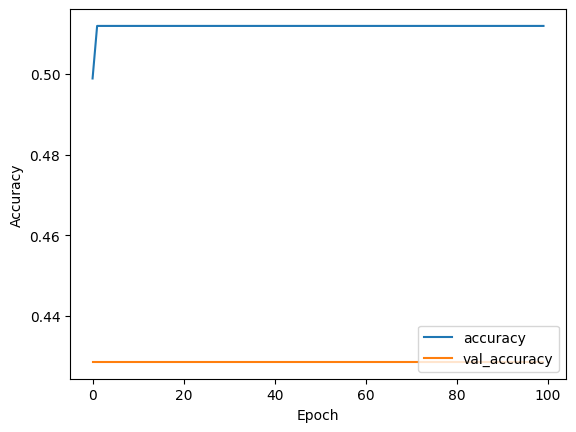

In [159]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
